In [1]:
import numpy as np
from matplotlib import cm
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
from rdkit.Chem.Draw import SimilarityMaps
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd

In [1]:
import sys
print(sys.path)

['C:\\Users\\zcemg08\\PycharmProjects\\biofuels\\"C:\\Users\\zcemg08\\AppData\\Local\\Continuum\\anaconda3\\python.exe', 'C:\\Users\\zcemg08\\AppData\\Local\\Continuum\\anaconda3\\envs\\skater-test\\Lib\\site-packages\\"', 'C:\\Users\\zcemg08\\Documents\\GitHub\\Mol_gan', 'C:\\Users\\zcemg08\\PycharmProjects\\biofuels', 'c:\\users\\zcemg08\\miniconda3\\envs\\env7\\python36.zip', 'c:\\users\\zcemg08\\miniconda3\\envs\\env7\\DLLs', 'c:\\users\\zcemg08\\miniconda3\\envs\\env7\\lib', 'c:\\users\\zcemg08\\miniconda3\\envs\\env7', '', 'c:\\users\\zcemg08\\miniconda3\\envs\\env7\\lib\\site-packages', 'c:\\users\\zcemg08\\miniconda3\\envs\\env7\\lib\\site-packages\\win32', 'c:\\users\\zcemg08\\miniconda3\\envs\\env7\\lib\\site-packages\\win32\\lib', 'c:\\users\\zcemg08\\miniconda3\\envs\\env7\\lib\\site-packages\\Pythonwin', 'c:\\users\\zcemg08\\miniconda3\\envs\\env7\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\zcemg08\\.ipython']


In [2]:
import os
os.environ['PYTHONPATH'].split(os.pathsep)

['"C:\\Users\\zcemg08\\AppData\\Local\\Continuum\\anaconda3\\python.exe',
 'C:\\Users\\zcemg08\\AppData\\Local\\Continuum\\anaconda3\\envs\\skater-test\\Lib\\site-packages\\"',
 'C:\\Users\\zcemg08\\Documents\\GitHub\\Mol_gan',
 '']

In [2]:
df = pd.read_csv(r'C:\Users\zcemg08\Desktop\important\RON_database_for_EF.csv',encoding="cp1252")

##### df - dataset to compare predictions with
df = df.dropna(axis = 0)
ron = pd.read_csv(r'C:\Users\zcemg08\Desktop\algo\ron_database_v1.0.csv',low_memory=False)
ron.columns = ron.iloc[0].values
ron = ron.drop(0,axis=0)
ron = ron[['Compound Name','PubChem CID','TARGET','SMILES']]
ron_biocompound = pd.read_table(r'C:\Users\zcemg08\Desktop\algo\RON.txt')
df_merged = df.merge(ron,on=['SMILES'],how='left')

ans = pd.read_csv(r'C:\Users\zcemg08\Desktop\algo\RON_database_for_EF.csv')

In [3]:
df = df.merge(ans,on=['SMILES'],how='left')
col = ['RON_Molecules_x','SMILES','Data Set','Exeriment']
df = df[col]
df['mols'] = [Chem.MolFromSmiles( x ) for x in df['SMILES'].values]

def func(x):
    if x>=94.4:
        return 1
    else:
        return -1
    
df['class'] = [func(x) for x in df['Exeriment'].values]

In [4]:
df.head(5)

,RON_Molecules_x,SMILES,Data Set,Exeriment,mols,class
0,n-Butylbenzene,CCCCc1ccccc1,Training,104.4,<rdkit.Chem.rdchem.Mol object at 0x0000016BC2D...,1
1,"1,2,3,4-Tetramethylbenzene",Cc1c(C)ccc(c1C)C,Training,105.3,<rdkit.Chem.rdchem.Mol object at 0x0000016BC2D...,1
2,1-Phenylpentane,CCCCCc1ccccc1,Training,89.2,<rdkit.Chem.rdchem.Mol object at 0x0000016BC2D...,-1
3,1-Methyl-2-allylbenzene,C=CCc1ccccc1C,Training,98.6,<rdkit.Chem.rdchem.Mol object at 0x0000016BC2D...,1
4,"1,2,3,4-Tetrahydronaphthalene",C1CCc2c(C1)cccc2,Training,96.4,<rdkit.Chem.rdchem.Mol object at 0x0000016BC5C...,1


In [5]:
trainmols = df[df['Data Set'].isin(['Training','Validation'])]['mols'].values

testmols  = df[df['Data Set']=='Test']['mols'].values

trainy    = df[df['Data Set'].isin(['Training','Validation'])]['class'].values

testy     = df[df['Data Set']=='Test']['class'].values

In [6]:
trainfps = [ AllChem.GetMorganFingerprintAsBitVect( mol,3 ) for mol in trainmols ]
testfps =  [ AllChem.GetMorganFingerprintAsBitVect( mol,3 ) for mol in testmols ]
 
trainx = []
for fp in trainfps:
    arr = np.zeros( (1,) )
    DataStructs.ConvertToNumpyArray( fp, arr )
    trainx.append( arr )
 
testx = []
for fp in testfps:
    arr = np.zeros( (1,) )
    DataStructs.ConvertToNumpyArray( fp, arr )
    testx.append( arr )

In [26]:
accuracy_score(testy,cls.predict(testx))

0.8461538461538461

In [25]:
cls = SVC( probability=True, C=20 )
cls.fit( trainx, trainy )

SVC(C=20, probability=True)

In [31]:
from rdkit.Chem.Draw import SimilarityMaps

# helper function
def getProba(fp, predictionFunction):     #### Probability Class 1 
    return predictionFunction((fp,))[0][1]
 
def mapperfunc( mol ):
    fig, maxweight = SimilarityMaps.GetSimilarityMapForModel(mol, SimilarityMaps.GetMorganFingerprint, lambda x: getProba(x, cls.predict_proba))
    fp = AllChem.GetMorganFingerprintAsBitVect( mol, 2 )
    arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray( fp, arr)
    arr = arr.reshape(1,2048)
    res = cls.predict( arr )
    smi = Chem.MolToSmiles( mol )
    #print(res[0])
    #if res[0] == 1:
     #   fig.savefig(r"C:\Users\zcemg08\Desktop\Vizualise_contributions\results5\high_octane"+"_.png",bbox_inches = "tight")
    #else:
     #   fig.savefig(r"C:\Users\zcemg08\Desktop\Vizualise_contributions\results5\low_octane"+"_.png",bbox_inches = "tight")
    #plt.fig()

In [32]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(testy, cls.predict(testx)))

[[11  2]
 [ 2 11]]


In [38]:
testmols = [Chem.MolFromSmiles(x)  for x in ['COC1=CC=CC=C1O','CCCc1cccc(c1)C','CC1C[C@@H](C)C[C@@H](C1)C','CC1[C@H](C)CCC[C@H]1C','CCC(C(=C)C)CC','CCC(C)C(=C)C','CNC1=CC=CC=C1']]

In [35]:
df.iloc[20:30]

,RON_Molecules_x,SMILES,Data Set,Exeriment,mols,class
20,"4,4-Diethyl-1-heptene",CCCC(CC=C)(CC)CC,Training,79.8,<rdkit.Chem.rdchem.Mol object at 0x0000016BC5C...,-1
21,"2-Methyl-1,3-butadiene",C=CC(=C)C,Training,99.1,<rdkit.Chem.rdchem.Mol object at 0x0000016BC5C...,1
22,2-Methyl-1-butene,CCC(=C)C,Training,102.5,<rdkit.Chem.rdchem.Mol object at 0x0000016BC5C...,1
23,3-Hexene (trans),CC/C=C/CC,Training,94.0,<rdkit.Chem.rdchem.Mol object at 0x0000016BC5C...,-1
24,2-Methyl-2-pentene,CCC=C(C)C,Training,97.8,<rdkit.Chem.rdchem.Mol object at 0x0000016BC5C...,1
25,2-Heptene (trans),CCCC/C=C/C,Training,73.4,<rdkit.Chem.rdchem.Mol object at 0x0000016BC5C...,-1
26,4-Methyl-2-hexene (cis),C/C=C\C(CC)C,Training,98.6,<rdkit.Chem.rdchem.Mol object at 0x0000016BC5C...,1
27,5-Methyl-2-hexene (trans),C/C=C/CC(C)C,Training,94.3,<rdkit.Chem.rdchem.Mol object at 0x0000016BC5C...,-1
28,"2,3-Dimethyl-1-pentene",CCC(C(=C)C)C,Training,99.3,<rdkit.Chem.rdchem.Mol object at 0x0000016BC5C...,1
29,ETHANE,CC,Training,111.7,<rdkit.Chem.rdchem.Mol object at 0x0000016BC5C...,1


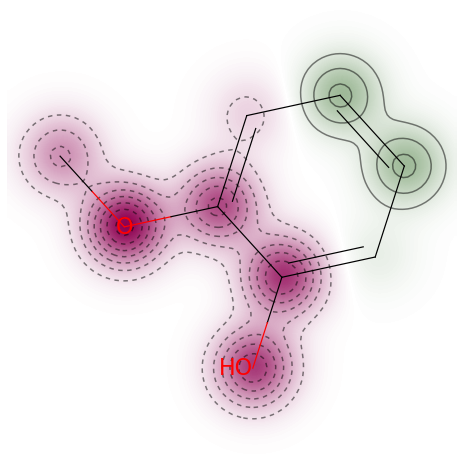

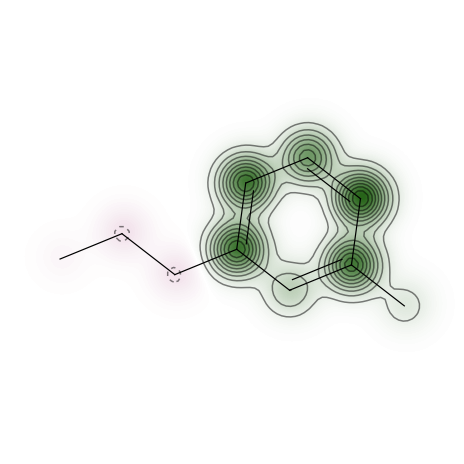

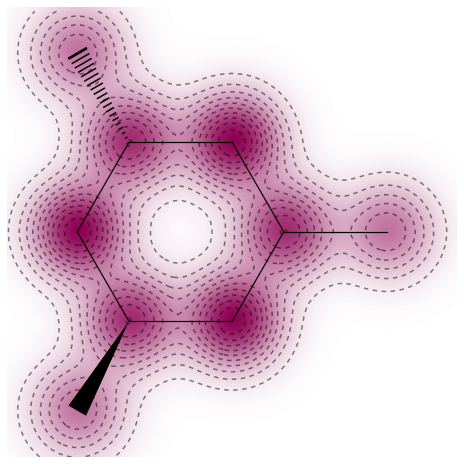

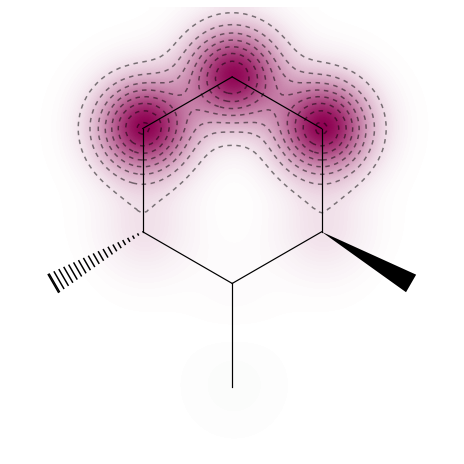

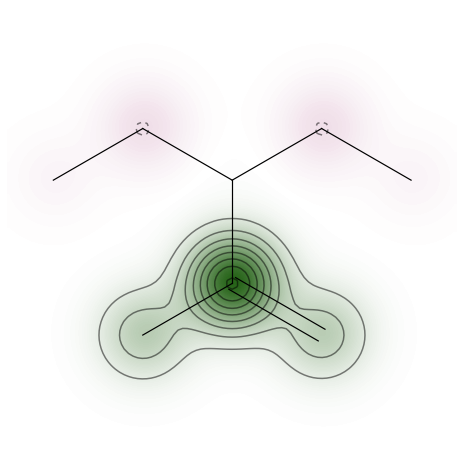

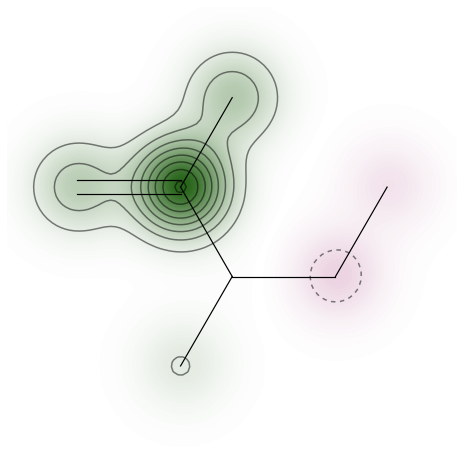

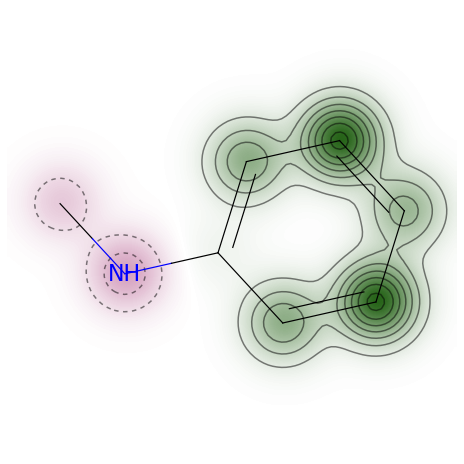

In [39]:
for mol in testmols:
    mapperfunc( mol )